## PID Kontroller Simulasjon

## Læringsmål
Etter å ha gjennomført denne øvelsen vil studenten kunne:

- Lage en enkel modell for en PID-kontroller (**Oppgave 1**, **Oppgave 2**)

- Numerisk integrere og differensiere bevegelsen til en bevegelig kropp (**Oppgave 2**)

- Implementere og analysere effektene av integral- og derivasjonstermer på systemets respons (**Oppgave 2**)

- (Bonus) Utforske hvordan et mer komplekst system påvirker PID-kontrollerens oppførsel (**Oppgave 3**)

## Introduksjon
Små droner er nå en del av alt fra lagerautomatisering til luftfotografering. Å holde dem stabile i luften er avgjørende for suksessen. Anta at vi ønsker å holde en drone nøyaktig 10 meter over bakken. Dette virker enkelt, bare påfør nok thrust til å motvirke tyngdekraften, ikke sant?

Men hvordan vet vi hvor mye thrust vi skal påføre? Og hva om omgivelsene ikke er stille? En vindkast kan dytte dronen opp eller ned, og vi må justere thrusten deretter. Hvordan gjør vi dette jevnt, uten at dronen svinger opp og ned?

Dette er et vanlig problem innen <a href="https://en.wikipedia.org/wiki/Control_theory">Kontroll teori</a>. For å holde dronen stabilt flyvende på riktig høyde trenger vi en metode for å justere hvor mye thrust som påføres. En metode for dette er å bruke en PID-kontroller. PID står for Proportional, Integral og Derivative, og er en type tilbakemeldingskontroller som regner ut hvor mye thrust som trengs basert på hvor langt dronen er fra ønsket høyde.

Den gjør dette ved å se på tre ting:

1. **Proportional (P)**: Hvor langt er dronen fra ønsket høyde akkurat nå? Hvis den er for lav, øk thrust. Hvis den er for høy, reduser thrust.

2. **Integral (I)**: Har dronen vært ute av posisjon over tid? Hvis den har vært for lav lenge, øk gradvis thrust for å korrigere dette. Dette hjelper til med å fjerne eventuelle konstante avvik.

3. **Derivative (D)**: Hvor raskt endrer høyden seg? Hvis dronen stiger for raskt, reduser thrust for å unngå overskytning. Hvis den faller raskt, øk thrust for å bremse fallet.

Det eneste PID-kontrolleren trenger å vite, er den faktiske høyden til dronen og målhøyden. Den sammenligner kontinuerlig disse for å beregne forskjellen, kalt error, og bruker deretter P-, I- og D-komponentene for å bestemme hvor mye thrust som skal påføres.

I dette prosjektet vil vi simulere en én-dimensjonal PID-kontroller som prøver å holde en drone stabil på ønsket høyde. Vi vil utforske hvordan de ulike komponentene i PID-kontrolleren påvirker responsen, og se hvordan en tilsynelatende enkel tilbakemeldingssløyfe kan gi kraftig reguleringsatferd.


## 1. Visualisering av systemet
Før vi kan simulere PID-kontrolleren, må vi forstå kreftene som virker på dronen. For å gjøre dette, begynner vi med å tegne et **fritt-legeme-diagram** for å visualisere disse kreftene.


### 1 a) Fritt-legeme-diagram
Skisser systemet og tegn et fritt-legeme-diagram av en drone som svever i en ønsket høyde 
ℎ
h. Siden vi jobber i én dimensjon (vertikalt), kan horisontale krefter ignoreres. Dronen påvirkes av to hovedkrefter: tyngdekraften, som trekker den nedover, og thrust, som skyver den oppover. Thrust-kraften styres via dronens "gasspedal", som justerer hvor mye oppoverrettet kraft som påføres for å motvirke tyngdekraften.

Tegn ett fritt-legeme-diagram for en lett drone og ett for en tung drone. Hva er forskjellen mellom de to?



![fbd.png](fbd.png)


### 1b) Endring i krefter

De frie legeme-diagrammene ovenfor beskriver dronen når den svever stabilt på mål høyden $h$, noe som betyr at det er en balanse mellom kreftene. Men hva skjer når dronen ikke er på ved ønsket høyde? Er kreftene fortsatt de samme?


**Løsning**: Nei, kreftene endrer seg avhengig av dronens høyde i forhold til målhøyden. Hvis dronen er under målhøyden, må thrust være større enn tyngdekraften for å løfte den opp. Hvis den er over målhøyden, må thrust være mindre enn tyngdekraften for at den skal kunne gå ned.

## 2. P-kontrolleren
Vi starter med å implementere den proporsjonale (P) komponenten i PID-kontrolleren. En proporsjonal kontroller justerer sin utgang basert på hvor langt dronen er fra målhøyden. Det betyr at jo større avvik, desto sterkere respons.

I vårt tilfelle er kontrollutgangen thrust-kraften som påføres dronen, skrevet som en funksjon av tid 
$u(t)$. Feilen er forskjellen mellom målhøyden og den nåværende høyden til dronen:
$$
u(t) = K_P e(t)
$$
hvor $K_P$ er den proporsjonale forsterkningen, $e(t)$ er feilen til tiden $t$, og $u(t)$ er den resulterende thrust-kraften.

En større feil gir altså mer thrust. I denne delen skal vi se på hvordan en proporsjonal kontroller alene påvirker dronens bevegelse, og hvorfor den ofte ikke er nok alene.

### 2 a) Finne akselerasjonen
For å simulere dronens bevegelse må vi beregne den vertikale akselerasjonen. Dette gjøres ved å finne netto kraft som virker på dronen, som er forskjellen mellom thrust-kraften og tyngdekraften. Tyngdekraften er konstant og kan representeres som $F_g = m \cdot g$, hvor $m$ er massen til dronen og $g$ er tyngdeakselerasjonen (omtrent 9.81 m/s²). 

Ved å bruke Newtons andre lov $F = ma$, uttrykk dronens akselerasjon $a(t)$ som en funksjon av thrust-kraften $u(t)$ og tyngdekraften $F_g$.

*Løsning:*
$$ a(t) = \frac{u(t) - F_g}{m} = \frac{u(t) - mg}{m}$$

### 2 b) Implementer akselerasjonsfunksjonen

Bruk uttrykket for akselerasjon, implementer funksjonen `acceleration(thrust, m, g)` som beregner den vertikale akselerasjonen til dronen.



In [1]:
import numpy as np #numpy brukes for å lagre tall of gjøre beregninger effektivt
import matplotlib.pyplot as plt  #matplotlib brukes for å lage grafer

In [2]:
def acceleration(thrust, m, g):
    """
    Calculates the net vertical acceleration of the drone.
    """
    return (thrust - m * g) / m

### 2 c) Den proporsjonale komponenten
Nå har vi implementert en funksjon for akselerasjon. Men som du ser, avhenger akselerasjonen av thrust-kraften $u(t)$, som vi ennå ikke har definert.

I denne deloppgaven ønsker vi å implementere to funksjoner:
1. `proportional_component(K_P, error)`  som beregner thrust-kraften $u(t)$ basert på den proporsjonale forsterkningen $K_P$ og feilen $e(t)$.
2. `error(target_height, current_height)` som beregner feilen $e(t)$ som forskjellen mellom ønsket høyde og nåværende høyde.

Dette er de to siste delene vi trenger for å implementere den proporsjonale komponenten i regulatoren.



In [3]:
def calculate_error(target_height, current_height):
    """
    Calculates the difference between the target height and the current height of the drone.
    """
    return target_height - current_height

def proportional_component(K_P, error):
  
    return K_P * error


### 2 d) Simuler den proporsjonale komponenten
Nå som vi har alle delene på plass, er vi klare til å simulere bevegelsen til dronen ved hjelp av den proporsjonale komponenten.

I kodeseksjonen nedenfor skal du implementere Euler-Cromer-metoden for å numerisk integrere hastigheten og posisjonen til dronen. Euler-Cromer-metoden er en utvidelse av Euler-metoden og er betydelig mer stabil og pålitelig for å simulere fysiske systemer når akselerasjonen er kjent.

Euler-Cromer-ligningene for dette systemet er:
\begin{align*}
    v(t + \Delta t) &= v(t) + a(t) \Delta t\\
    r(t + \Delta t) &= r(t) + v(t + \Delta t) \Delta t
\end{align*}
hvor $v(t)$ er hastigheten ved tidspunkt $t$, $r(t)$ er posisjonen ved tidspunkt $t$, og $\Delta t$ er tidssteget.

In [4]:
## initialiser systemet
m = 1.0  # masse
target_height = 10 # ønsket posisjon E.g 10.0
start_position = 0.0 # initial posisjon
start_velocity = 0.0 # initial hastighet
g = 9.81  # tyngdeakselerasjon
K_P = 5.0  # proporsjonal forsterkning


n = 500
T = np.linspace(0, 20, n)  # tidsvektor
dt = T[1] - T[0]  # tidssteg

position = np.zeros(n)  # posisjon
velocity = np.zeros(n)  # hastighet
accelerations = np.zeros(n)  # akselerasjon
position[0] = start_position  # sett initial posisjon
velocity[0] = start_velocity  # sett initial hastighet

In [5]:
# Euler cromer metode for numerisk integrasjon
for i in range(1, n):
    error = calculate_error(target_height, position[i-1])
    thrust = proportional_component(K_P, error)

    accelerations[i] = acceleration(thrust, m, g)

    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

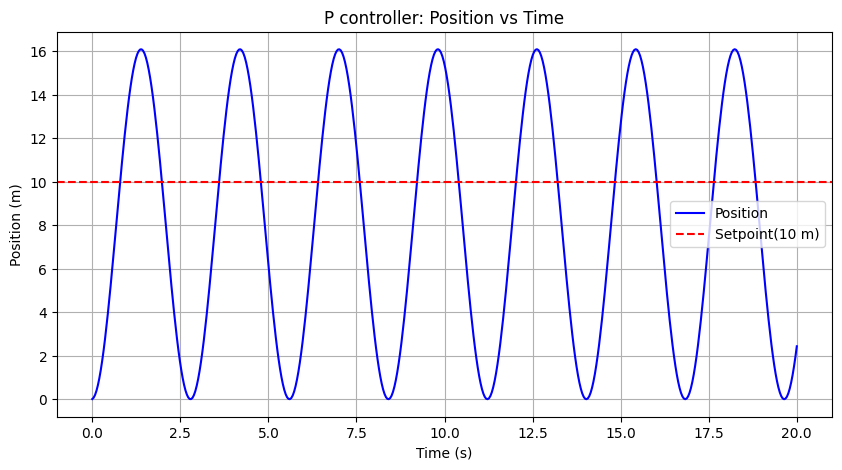

In [6]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(target_height, color='red', linestyle='--', label=f'Setpoint({target_height} m)')
plt.title('P controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()    

Resultatene dine ser kanskje ganske dårlige ut i starten, men det er ventet. P-kontrollen er ikke veldig god til å holde dronen stabil. Derfor er neste steg å legge til den deriverte komponenten i kontrolleren.


## 3) PD-kontroller
Vi har nettopp sett begrensningene til en P-kontroller. Den reagerer kun på den nåværende feilen, altså forskjellen mellom ønsket høyde og målt posisjon, uten å ta hensyn til hvordan feilen endrer seg over tid. Dette fører ofte til oversvingninger og oscillasjoner i systemet.

For å forbedre kontrolleren introduserer vi en deriverende komponent, D, som reagerer på endringshastigheten til feilen. Dette lar kontrolleren forutse hvor systemet er på vei, ikke bare hvor det er nå. Med andre ord fungerer den deriverende komponenten som en anticiperende kontroll, som presser tilbake sterkere når feilen endrer seg raskt, og demper responsen når ting stabiliserer seg. Den tilfører effektivt demping, noe som bidrar til å jevne ut responsen og forhindre oversvingninger.

Matematisk er kontrollsignalet nå proporsjonalt med både feilen og dens derivert:
$$u(t) = K_p e(t) + K_D \frac{∂ e(t)}{∂ t}$$


### 3 a) Forstå den deriverende komponenten
Før vi implementerer den deriverende komponenten, la oss først prøve å forstå hvordan den påvirker systemet. Den deriverende komponenten er endringshastigheten til feilen, som kan approksimeres ved:
$$\frac{∂ e(t)}{∂ t} \approx \frac{e(t) - e(t - \Delta t)}{\Delta t}$$
hvor $\Delta t$ er tidssteget, $e(t)$ er feilen ved tidspunkt $t$, og $e(t - \Delta t)$ er feilen ved forrige tidssteg.

Tenk nå gjennom disse situasjonene:

1. Hva skjer med thrust-kraften $u(t)$ når dronen er under ønsket høyde, men stiger raskt?

2. Hva skjer med thrust-kraften $u(t)$ når dronen er over ønsket høyde, og faller tilbake mot den?

3. Hva skjer med thrust-kraften $u(t)$ når dronen er i en stabil høyde (ikke nødvendigvis ønsket høyde)?

*Tips: Tenk på fortegnet til feilen og fortegnet til dens derivert i hver situasjon.*

**Løsning**:

1. Feilen er positiv: $\text{målhøyde} - \text{nåværende høyde} > 0$, og den deriverte er negativ: $\frac{∂ e(t)}{∂ t} < 0$. Da er P-komponenten positiv og D-komponenten negativ. Nettoeffekten er at D-komponenten reduserer den totale thrust sammenlignet med kun P-komponenten. Den demper responsen for å unngå overskyting.
2. Feilen er negativ: $\text{målhøyde} - \text{nåværende høyde} < 0$, og den deriverte er positiv: $\frac{∂ e(t)}{∂ t} > 0$. Da er P-komponenten negativ og D-komponenten positiv. Nettoeffekten er at D-komponenten motvirker P-komponenten. Thrust økes sammenlignet med en ren P-kontroller, og demper nedstigningen.
3. Når dronen er på en stabil forskjøvet posisjon, er feilen konstant: $\text{målhøyde} - \text{nåværende høyde} = C$, der $C$ er en konstant. Den deriverte er null: $\frac{∂ e(t)}{∂ t} = 0$. Dronen svever da på en forskjøvet posisjon der thrust fra kun P-leddet balanserer tyngdekraften. Dette er en kjent begrensning ved PD-kontrolleren. De kan ikke eliminere stasjonære feil.

### 3 b) Implementering av den deriverende komponenten
Det neste vi må gjøre er å implementere derivert av feilen i simuleringen. En enkel måte å beregne derivert på er å bruke forskjellen mellom den nåværende og forrige feilen:
$$\frac{∂ e(t)}{∂ t} = \frac{e(t) - e(t-1)}{Δt}$$
Fyll ut funksjonen `derivative_component(K_D, error, previous_error, dt)` nedenfor.

In [7]:
def derivative_component(K_D, current_error, previous_error, dt):
    """
    Derivative term for a PID controller: K_D ⋅ (∂ e(t))/(∂ t).
    """
    derivative = (current_error - previous_error) / dt
    return K_D * derivative

### 3 c) Simulering av PD-kontrolleren
Nå som du har implementert den deriverende komponenten, er du klar til å simulere dronens bevegelse ved bruk av PD-kontrolleren.

Bruk Euler-Cromer-metoden for numerisk integrasjon av dronens hastighet og posisjon. PD-kontrolleren vil bruke både den proporsjonale og den deriverte komponenten for å beregne drivkraften. Lag også en plot av resultatet og observer hvordan det endrer seg sammenlignet med P-kontrolleren.

In [8]:
K_P = 5.0  # proporsjonal forsterkning
K_D = 5.0  # derivert forsterkning

position = np.zeros(n)  # posisjon
velocity = np.zeros(n)  # hastighet
accelerations = np.zeros(n)  # akselerasjon
position[0] = start_position  # sett initial posisjon
velocity[0] = start_velocity  # sett initial hastighet

In [10]:
#Euler-Cromer metode for numerisk integrasjon med PD kontroller
previous_error = 0.0 # initialiser tidligere feil

for i in range(1, n):
    error = calculate_error(target_height, position[i-1])# Regn ut feil

    # Regn ut kontroll input ved bruk av den proporsjonale og deriverte komponenten
    P = proportional_component(K_P, error)
    D = derivative_component(K_D, error, previous_error, dt)

    thrust = P + D # Legg sammen

    accelerations[i] = acceleration(thrust, m, g)

    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error

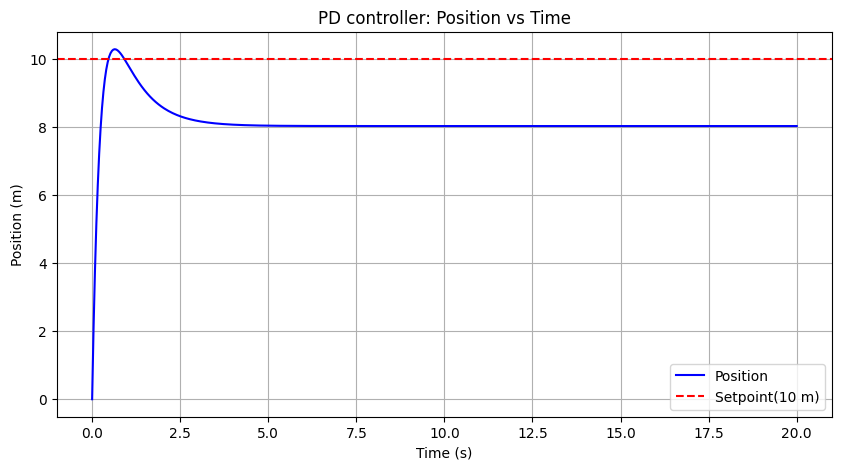

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(target_height, color='red', linestyle='--', label=f'Setpoint({target_height} m)')
plt.title('PD controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

Forhåpentligvis har du nå sett en forbedring i stabiliteten til dronen. PD-kontrolleren er mye bedre til å holde dronen stabil enn når vi kun hadde P-kontrolleren. Men vi kan fortsatt se at vi ikke er helt der ennå. Igjen, ikke bekymre deg, vi vil forbedre kontrolleren en gang til ved å legge til den integrerte termen.


## 4) PID-kontroller
Vi har nå sett effekten av P- og D-leddene i kontrolleren. Selv om derivasjonsleddet hjelper ved å forutse endringer i feilen og dempe systemresponsen, er PD-kontrolleren fortsatt ikke perfekt, spesielt når det gjelder å eliminere stasjonære feil, der dronen svever på en høyde som ikke er nøyaktig den ønskede høyden.

For å løse dette problemet vil vi introdusere integral-leddet, I. Integral-leddet akkumulerer feilen over tid, og "husker" tidligere feil. Hvis det er en vedvarende forskjell mellom målet og målingen, vil integral-leddet fortsette å vokse, og presse kontrolleren til å justere utgangen til feilen er eliminert. Denne kumulative effekten gjør at kontrolleren kan fjerne gjenværende eller statiske feil som det proporsjonale leddet alene ikke kan håndtere.

Etter hvert som feilen minker, vil bidraget fra det proporsjonale leddet naturlig svekkes, men integral-leddet, som har bygget seg opp over tid, fortsetter å drive utgangen til feilen er null. Når feilen når null, slutter integral-leddet å vokse, og systemet stabiliseres.

Sammen kombineres de tre leddene til en PID-kontroller, som er definert slik:

$$u(t) = K_P e(t) + K_I \int_0^t e(t) dt + K_D \frac{∂ e(t)}{∂ t} $$

### 4 a) Implementering av integral-leddet
Vi ønsker å implementere integralet av feilen i simuleringen ved å bruke en enkel numerisk integrasjonsmetode, som et Riemann-sum: 
$$\int_0^t e(t) dt \approx \sum_{i=0}^{n} e(t_i) \Delta t$$
Riemann-summen vil akkumuleres i en variabel, som må initialiseres til null, og deretter oppdateres i hver iterasjon av simuleringsløkken.

Fyll ut funksjonen integration_component(K_I, Riemann_sum) nedenfor.

In [15]:
def integration_component(K_I, Riemann_sum):
    """
    Integral term for a PID controller: K_I ⋅ ∑ e(t)⋅Δt
    """
    return K_I * Riemann_sum

### 4 b) Simulering av PID-kontrolleren
Nå som du har implementert alle nødvendige funksjoner for PID-kontrolleren, skal du kunne simulere dronens bevegelse ved å bruke PID-kontrolleren kombinert med Euler-Cromer-metoden.

In [14]:
# Initialiser systemet
K_P = 10  # proporsjonal forsterkning
K_D = 5   # derivasjonsforsterkning
K_I = 5   # integral forsterkning

position = np.zeros(n)  # posisjon
velocity = np.zeros(n)  # hastighet
accelerations = np.zeros(n)  # akselerasjon
position[0] = start_position  # sett initial posisjon
velocity[0] = start_velocity  # sett initial hastighet


In [16]:
# Euler-Cromer for numerisk integrasjon with PID control
previous_error = 0  # initialize previous error
Riemann_sum = 0 # initialize riemann sum

for i in range(1, n):
    error = calculate_error(target_height, position[i-1])
    Riemann_sum = Riemann_sum + error * dt  
    
    P = proportional_component(K_P, error)
    
    D = derivative_component(K_D, error, previous_error, dt)

    I = integration_component(K_I, Riemann_sum)

    thrust = P + I + D  
    
    accelerations[i] = acceleration(thrust, m, g)

    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error

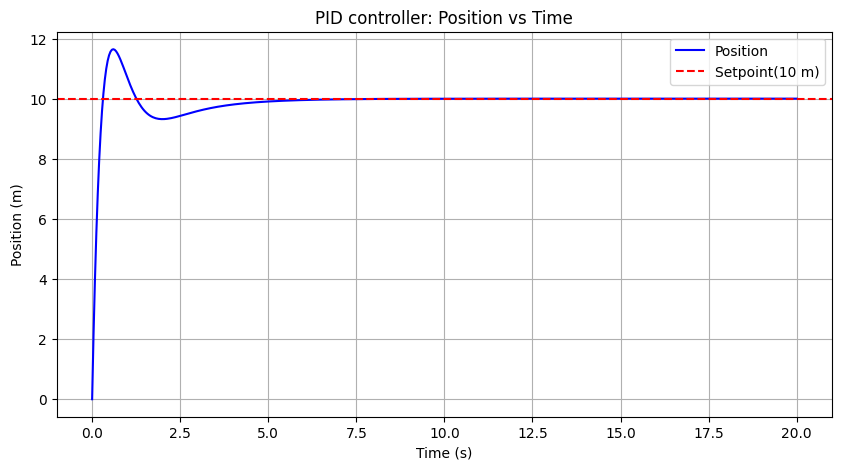

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(target_height, color='red', linestyle='--', label=f'Setpoint({target_height} m)')
plt.title('PID controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()


Forhåpentligvis har du nå sett en betydelig forbedring i dronens stabilitet. Din PID-kontroller bør nå kunne holde dronen stabilt på ønsket høyde.

Prøv nå å justere verdiene for $K_P$, $K_I$ og $K_D$ for å se hvordan de påvirker systemets respons. Du kan også eksperimentere med å endre målhøyden og observere hvordan kontrolleren reagerer på ulike ønskede høyder.

## 5. Legg til tilfeldige effekter
I den virkelige verden er det ofte tilfeldige effekter som kan påvirke stabiliteten til dronen. For eksempel kan vindkast dytte dronen opp eller ned, og vi må justere thrusten deretter. I denne oppgaven skal vi legge til en tilfeldig effekt i simuleringen for å se hvordan PID-kontrolleren reagerer på dette.

Vi har laget noen eksempelfunksjoner for å simulere effektene som er listet opp nedenfor. Prøv å implementere dem i simuleringen din for å se hvordan PID-kontrolleren reagerer. Du kan også lage dine egne tilfeldige effekter og observere kontrollerens respons.

### Eksempler:
- Vindkast
- Luftmotstand
- Bevegelig målhøyde

### 5 a) Fritt-legeme-diagram med tilfeldige effekter
Før du implementerer effektene, tegn først et fritt-legeme-diagram av dronen som inkluderer de tilfeldige effektene du ønsker å utforske. Hvordan endrer disse effektene kreftene som virker på dronen, og hvordan påvirker de thrust-kraften som PID-kontrolleren må påføre?

*Plasser diagrammet her*

In [19]:
def drag_force(v, drag_coeff):
    """
    Calculates the drag force acting on the drone.
    """
    return -drag_coeff * v

def wind_force(wind_amplitude):
    """
    Randomly generates a wind
    """
    return np.random.uniform(-wind_amplitude, wind_amplitude)


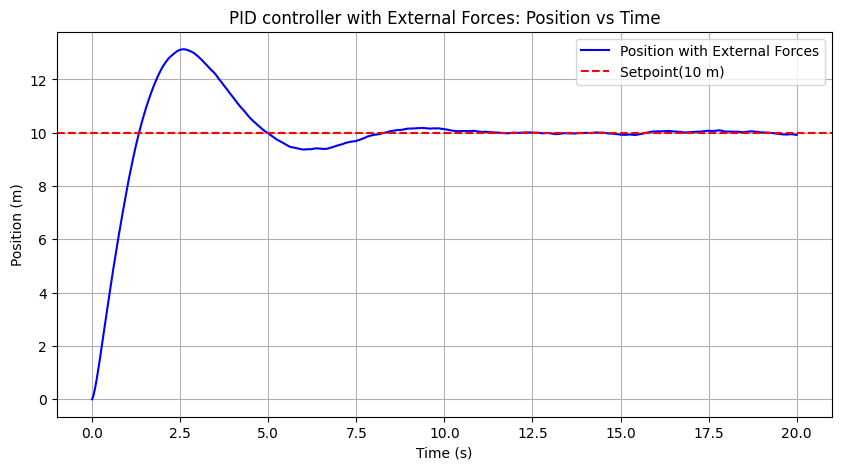

In [20]:
K_P = 10.0  
K_D = 10.0   
K_I = 10.0   

position = np.zeros(n) 
velocity = np.zeros(n)  
accelerations = np.zeros(n)  
position[0] = start_position  
velocity[0] = start_velocity  


previous_error = calculate_error(target_height, position[0])  
Riemann_sum = 0.0  

for i in range(1, n):
    error = calculate_error(target_height, position[i-1])

    Riemann_sum = Riemann_sum + error * dt  # Riemann

    P = proportional_component(K_P, error)

    D = derivative_component(K_D, error, previous_error, dt)

    I = integration_component(K_I, Riemann_sum)

    thrust = P + I + D 

    accelerations[i] = acceleration(thrust, m, g)
    accelerations[i] =  accelerations[i] + (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  # add external forces

    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  


plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.axhline(target_height, color='red', linestyle='--', label=f'Setpoint({target_height} m)')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

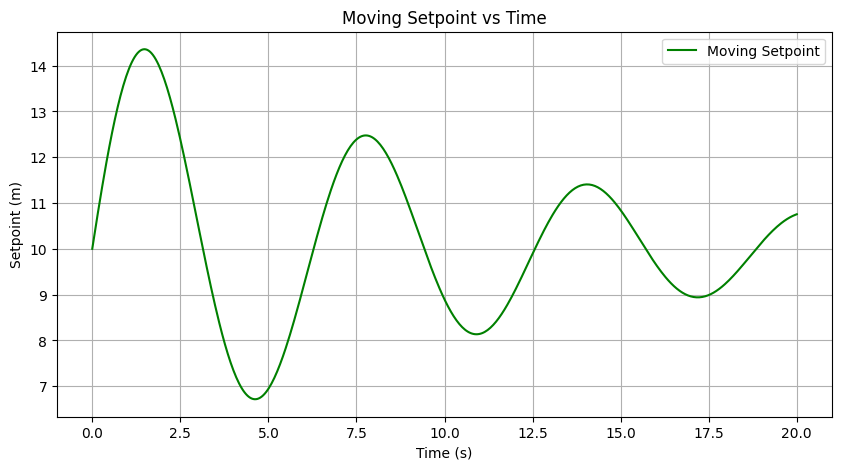

In [21]:
## bevegende mål
def moving_target(t):
    """
    Example function of a moving target that changes over time.
    """
    return 10.0 + 5.0 * np.sin(1.0 * t) * np.exp(-0.09 * t)

#plot målet
moving_targets = moving_target(T)
plt.figure(figsize=(10, 5))
plt.plot(T, moving_targets, label='Moving Setpoint', color='green')
plt.title('Moving Setpoint vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Setpoint (m)')
plt.legend()
plt.grid()
plt.show()

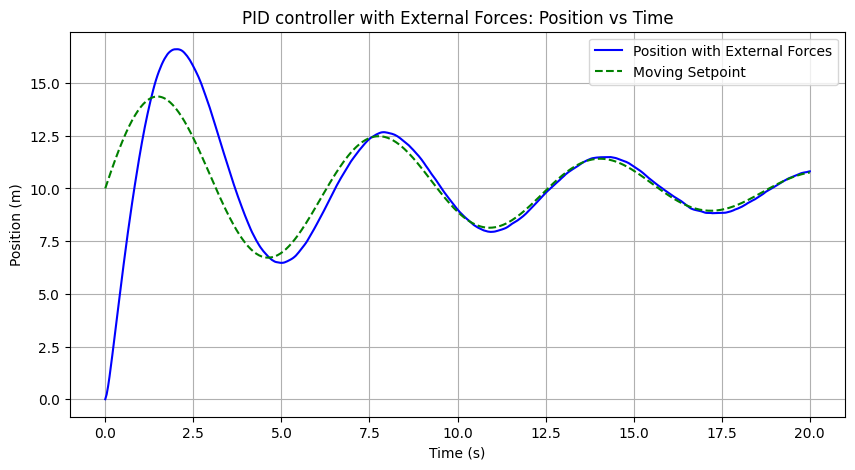

In [24]:
K_P = 10.0  
K_D = 10.0   
K_I = 10.0   

position = np.zeros(n)  
velocity = np.zeros(n)  
accelerations = np.zeros(n)  
position[0] = start_position  
velocity[0] = start_velocity  


previous_error = calculate_error(moving_targets[0], position[0])  
Riemann_sum = 0.0  

for i in range(1, n):
    error = calculate_error(moving_targets[i], position[i-1])

    Riemann_sum = Riemann_sum + error * dt 
    
    P = proportional_component(K_P, error)
    
    D = derivative_component(K_D, error, previous_error, dt)
    
    I = integration_component(K_I, Riemann_sum)

    thrust = P + I + D
    
    accelerations[i] = acceleration(thrust, m, g)
    accelerations[i] += (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  
    
    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  


plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.plot(T, moving_targets, label='Moving Setpoint', color='green', linestyle='--')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()